In [105]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statistics
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')


In [106]:
train_df = pd.read_csv('archive/train.csv')

In [107]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [108]:
#Descriptive statistics for the numerical columns
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [109]:
#Descriptive statistics for the non-numerical columns
train_df.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x4607,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


In [110]:
train_df.rename(columns= {'Weatherconditions': 'Weather_conditions'}, inplace=True)

In [111]:
#Data Extraction
def extract_column_value(df):
    df['Time_taken(min)'] = df['Time_taken(min)'].str.split().str[1].astype(int)
    df['Weather_conditions'] = df['Weather_conditions'].str.split().str[1]
    df['City_code']=df['Delivery_person_ID'].str.split("RES", expand=True)[0]

extract_column_value(train_df)
train_df[['Time_taken(min)', 'Weather_conditions', 'City_code']].head()


,Time_taken(min),Weather_conditions,City_code
0,24,Sunny,INDO
1,33,Stormy,BANG
2,26,Sandstorms,BANG
3,21,Sunny,COIMB
4,30,Cloudy,CHEN


In [112]:
#Update datatypes
def update_datatype(df):
    #Update datatype from object to float
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    #Update datatype from object to datetime
    df['Order_Date']=pd.to_datetime(df['Order_Date'],format="%d-%m-%Y")
    
update_datatype(train_df)

In [113]:
#Dropping unecessary columns
train_df.drop(['ID', 'Delivery_person_ID'], axis=1, inplace=True)


In [114]:
#Checking duplicate values
if (len(train_df[train_df.duplicated()])>0):
    print ("There are duplicate values present")
else:
    print("There is no duplicate value present")


There is no duplicate value present


In [115]:
#Missing value handling
train_df.replace('NaN', float(np.nan), regex=True, inplace=True)

train_df.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weather_conditions              616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
City_code                         0
dtype: int64

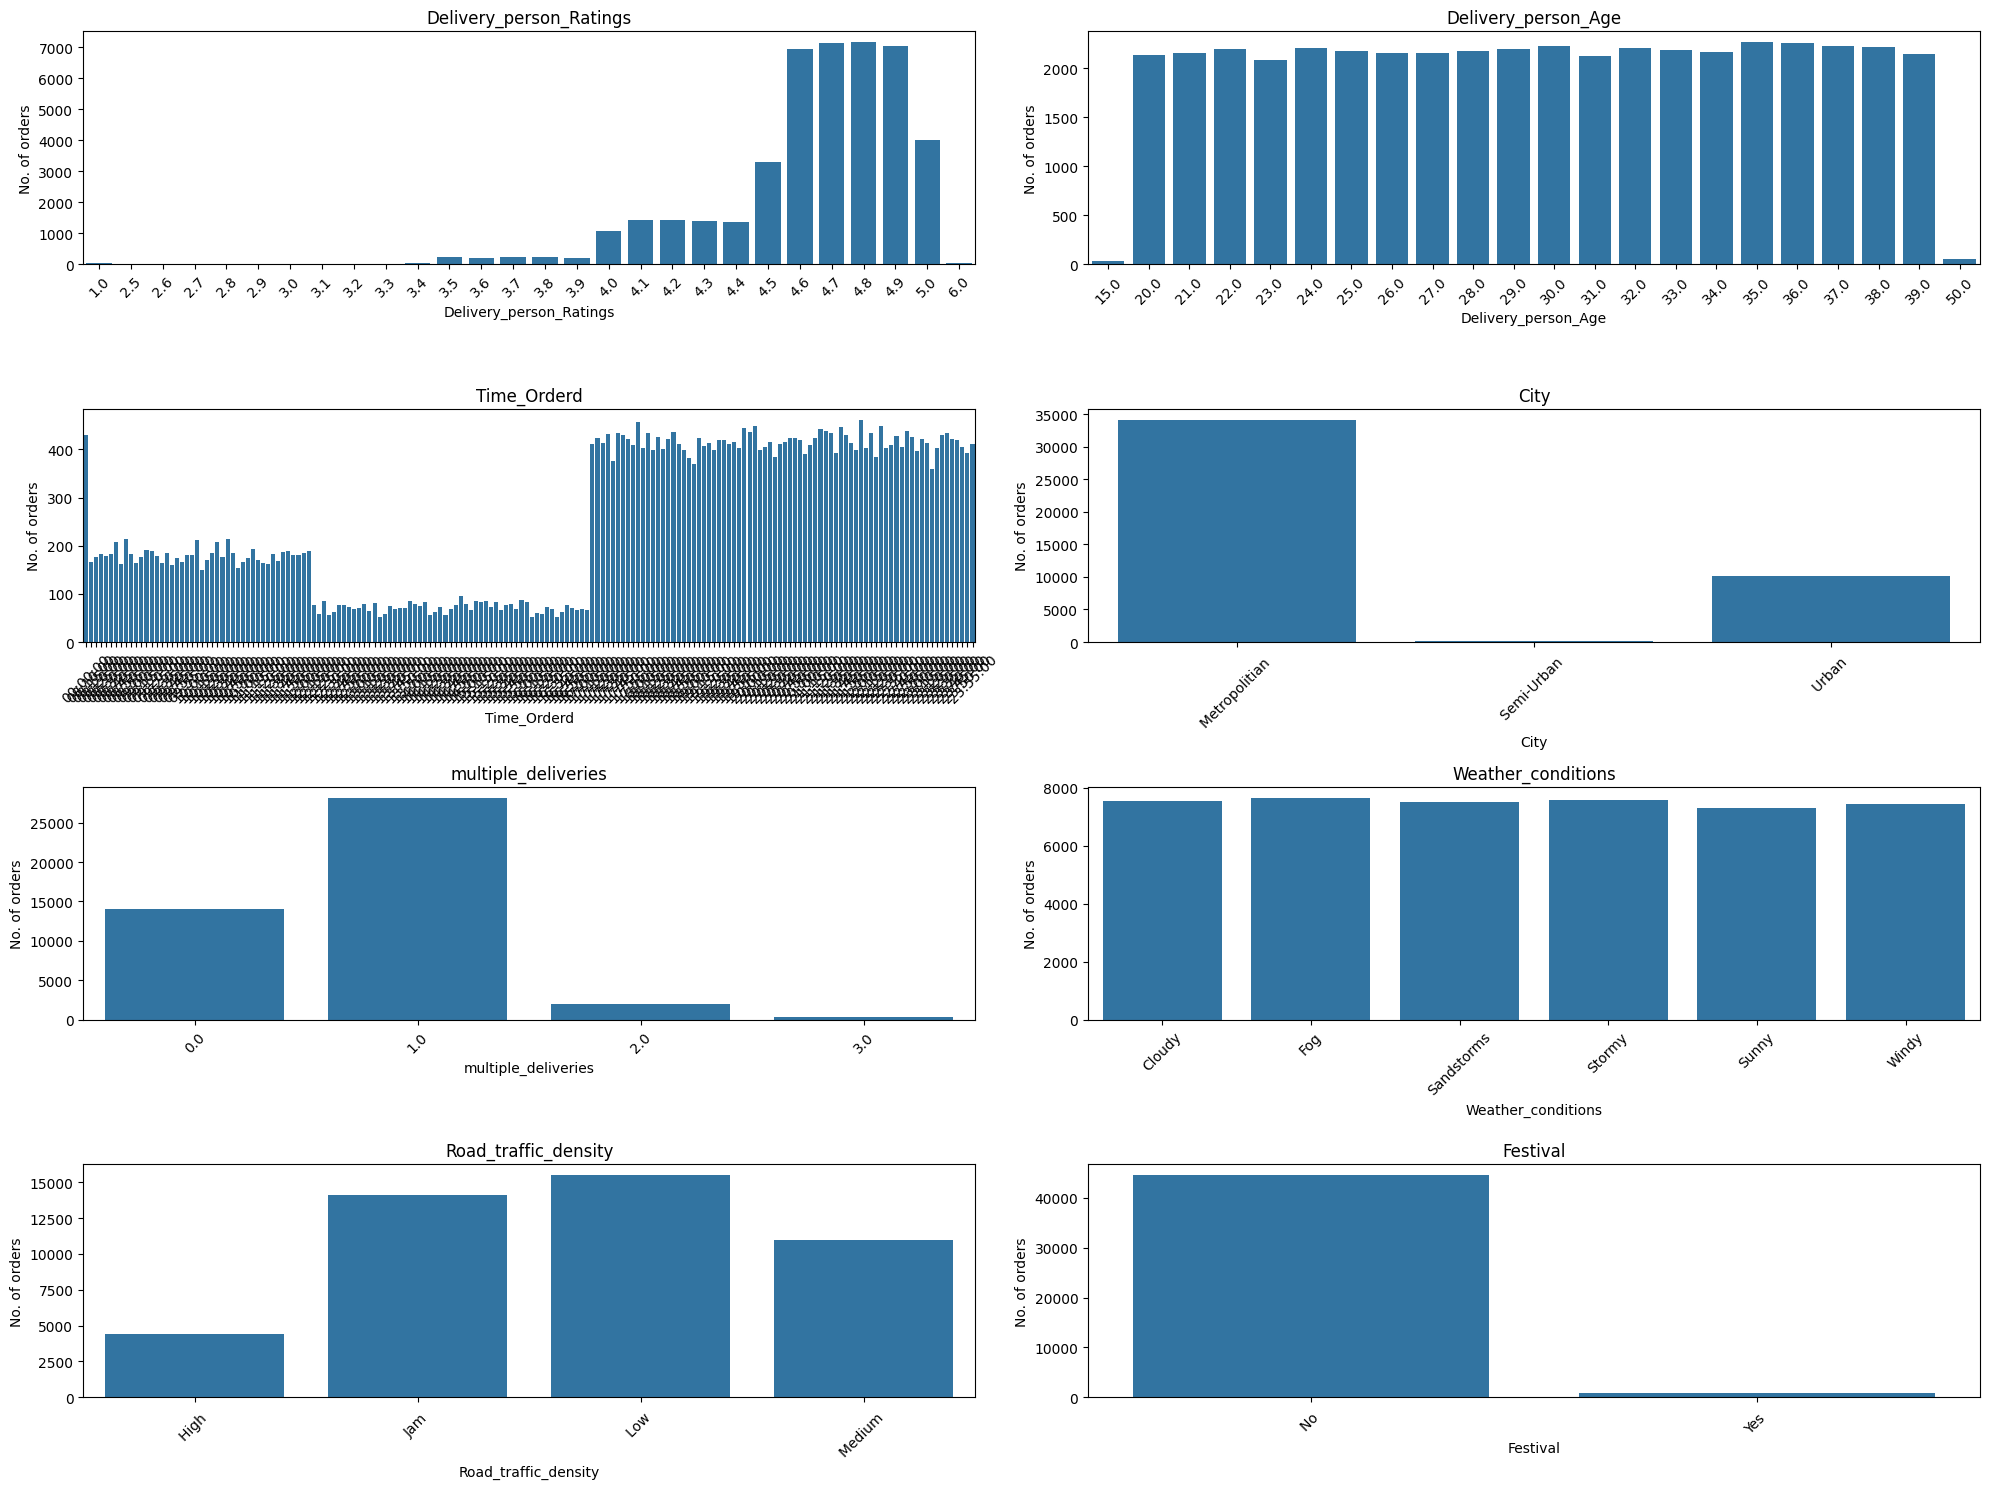

In [116]:
#Data visualisation
cols = ['Delivery_person_Ratings', 'Delivery_person_Age',
'Time_Orderd', 'City', 'multiple_deliveries', 
'Weather_conditions', 'Road_traffic_density', 'Festival' ]
num_plots = len(cols)
num_rows = (num_plots // 2 ) + (num_plots % 2)

fig, axes = plt.subplots (num_rows, 2, figsize= (20, 15))

for i, column_name in enumerate (cols):
    row = i // 2
    col = i % 2

    ax = axes [row, col]
    sns.countplot(data=train_df, x= column_name, 
    order=train_df[column_name].value_counts().sort_index().index, ax=ax)

    ax.set_xlabel(column_name)
    ax.set_ylabel('No. of orders')
    ax.set_title(column_name)
    ax.tick_params (axis='x', rotation=45)

if num_plots % 2 !=0:
    fig.delaxes(axes[-1,-1])

plt.tight_layout()
plt.show()

In [117]:
#Handling null values
def handle_null_values(df):
    #random choice
    train_df['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True )
    train_df['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True )
    #mode
    train_df['City'].fillna(df['City'].mode()[0], inplace=True )
    train_df['Festival'].fillna(df['Festival'].mode()[0], inplace=True )
    train_df['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
    train_df['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
    #median
    train_df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)

handle_null_values(train_df)
train_df.isnull().sum()

Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions                0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
City_code                         0
dtype: int64

In [118]:
def extract_date_features(data):
    data["day"] = data.Order_Date.dt.day
    data["month"] = data.Order_Date.dt.month
    data["quarter"] = data.Order_Date.dt.quarter
    data["year"] = data.Order_Date.dt.year
    data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
    data["is_month_start"] = data.Order_Date.dt.is_month_start.astype(int)
    data["is_month_end"] = data.Order_Date.dt.is_month_end.astype(int)
    data["is_quarter_start"] = data.Order_Date.dt.is_quarter_start.astype(int)
    data["is_quarter_end"] = data.Order_Date.dt.is_quarter_end.astype(int)
    data["is_year_start"] = data.Order_Date.dt.is_year_start.astype(int)
    data["is_year_end"] = data.Order_Date.dt.is_year_end.astype(int)
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]),1,0)

extract_date_features(train_df)

In [119]:
#Calculate Time Differnce 
def calculate_time_diff(df):
    # Find the difference between ordered time & picked time
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])
    
    df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(df['Time_Order_picked'] < df['Time_Orderd'], pd.DateOffset(days=1), pd.DateOffset(days=0)) + df['Time_Order_picked']
    
    df ['Time_Order_picked_formatted'] = pd.to_datetime(df['Time_Order_picked_formatted'])

    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60
    
    # Handle null values by filling with the median
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)
    
    # Drop all the time & date related columns
    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)

calculate_time_diff(train_df)


In [120]:
#Calculate distance between restaurant location & delivery location
def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']= df['distance'].astype("str").str.extract('(\d+)').astype("int64")
    
calculate_distance(train_df)

In [121]:
def label_encoding(df):
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))

label_encoding(train_df)

In [122]:
X = train_df.drop('Time_taken(min)', axis=1)  # Features
y = train_df['Time_taken(min)']  # Target variable

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [123]:
# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Perform standardization on the training data
X_train = scaler.transform(X_train)

# Perform standardization on the testing data
X_test = scaler.transform(X_test)

In [124]:
from sklearn.impute import SimpleImputer

# Create an imputer object
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data
X_train_imputed = imputer.fit_transform(X_train)

# Use the fitted imputer to transform the test data
X_test_imputed = imputer.transform(X_test)


In [125]:
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]

param_grid = [
    {},  
    {'max_depth': [3, 5, 7]},
    {'n_estimators': [100, 200, 300]}
]

for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    print(f"{model.__class__.__name__}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best R2 score:", grid_search.best_score_)
    print()


LinearRegression:
Best parameters: {}
Best R2 score: 0.415914595140201

DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best R2 score: 0.7171925170453282

RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best R2 score: 0.8127345470401324

